In [1]:
import scipy.ndimage
import pandas as pd
import re
import glob
import numpy as np

losses_dict = {}
model_file_dict = {}
lr_dict = {}
wallclock_dict = {}

for name in glob.glob("log/*.log"):
    with open(name) as f:
        log = f.read()
    
    model_file = re.findall(r"Saving model to (.*)", log)
    shortname = name.split(".")[0].split("/")[1]
    model_file_dict[shortname] = model_file[-1] if model_file else ""
    losses_dict[shortname] = [float(v) for v in re.findall(r'mean loss (.*) \|', log)]
    lr_dict[shortname] =  [float(v) for v in re.findall(r'lr (.*) data', log)]
    wallclock_dict[shortname] = np.NaN


In [2]:
import torch

last_saves = dict()
for name in glob.glob("models_diff/*.cpkt"):
    if "prior_diff_real" in name:
        continue
    shortname, epoch_string = name.split("/")[1].split("_epoch_")
    epoch_string = epoch_string.split(".")[0]
    if epoch_string == "on_exit":
        epoch = np.inf
    else:
        epoch = int(re.findall("(\d+)", epoch_string)[0])
    if shortname in last_saves:
        if last_saves[shortname][1] < epoch:
            last_saves[shortname] = (name, epoch)
    else:
        last_saves[shortname] = (name, epoch)

for shortname, (name, _) in last_saves.items():
    _, _, config = torch.load(name, map_location="cpu")
    if "losses" in config:
        losses_dict[shortname] = config['losses']
    if "wallclock_time" in config:
        wallclock_dict[shortname] = config['wallclock_time']
    elif "wallclock_times" in config:
        wallclock_dict[shortname] = config['wallclock_times']
    else:
        wallclock_dict[shortname] = np.NaN
    lr_dict[shortname] = config.get("learning_rates", np.NaN)

/anaconda/envs/tabpfn/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
last_saves

{'reproduce_reference_config_continue_06_05_2023_17_45_06': ('models_diff/reproduce_reference_config_continue_06_05_2023_17_45_06_epoch_on_exit.cpkt',
  inf),
 'tabpfn_large_lr00003_warm_start_06_06_2023_17_06_35': ('models_diff/tabpfn_large_lr00003_warm_start_06_06_2023_17_06_35_epoch_on_exit.cpkt',
  inf),
 'vanilla_lr0001_new_05_31_2023_23_16_43': ('models_diff/vanilla_lr0001_new_05_31_2023_23_16_43_epoch_290.cpkt',
  290),
 'download': ('models_diff/download_epoch_100.cpkt', 100),
 'vanilla_tabpfn_lr0001_post_refactor_try_reproduce_06_02_2023_00_02_28': ('models_diff/vanilla_tabpfn_lr0001_post_refactor_try_reproduce_06_02_2023_00_02_28_epoch_210.cpkt',
  210),
 'reproduce_reference_config_06_02_2023_17_08_59': ('models_diff/reproduce_reference_config_06_02_2023_17_08_59_epoch_on_exit.cpkt',
  inf),
 'tabpfn_large_lr0001_06_05_2023_18_57_22': ('models_diff/tabpfn_large_lr0001_06_05_2023_18_57_22_epoch_on_exit.cpkt',
  inf),
 'tabpfn_large_lr0001_06_05_2023_23_08_11': ('models_diff/t

In [45]:
def make_long_loss_df(losses_dict, smooth=None):
    def trim(series, skip):
        if pd.api.types.is_scalar(series):
            return series
        return series[skip:-skip-1]
    
    dfs = []
    for name, losses in losses_dict.items():
        if smooth is not None:
            smoothed_losses = smooth(losses)
            skip = (len(losses) - len(smoothed_losses)) // 2
            if skip < 0:
                continue
            this_df = pd.DataFrame({"loss": smoothed_losses,
                                    "learning_rate": trim(lr_dict[name], skip),
                                    "time": trim(wallclock_dict[name], skip),
                                    "epoch": trim(np.arange(len(losses)), skip)})
        else:
            this_df = pd.DataFrame({"loss": losses, "learning_rate": lr_dict[name], "time": wallclock_dict[name], "epoch": np.arange(len(losses))})
        
        this_df['run'] = name
        dfs.append(this_df)
    return pd.concat(dfs)

In [46]:
make_long_loss_df(losses_dict)

,loss,learning_rate,time,epoch,run
0,2.241400,0.000000,NaN,0,predict_embed_4096_lr_0001_nhead_16
1,1.272400,0.000005,NaN,1,predict_embed_4096_lr_0001_nhead_16
2,0.830100,0.000010,NaN,2,predict_embed_4096_lr_0001_nhead_16
3,0.792500,0.000015,NaN,3,predict_embed_4096_lr_0001_nhead_16
4,0.718700,0.000020,NaN,4,predict_embed_4096_lr_0001_nhead_16
...,...,...,...,...,...
395,0.488310,0.000053,NaN,395,mothernet_from_scratch_again_06_28_2023_20_51_25
396,0.513832,0.000053,NaN,396,mothernet_from_scratch_again_06_28_2023_20_51_25
397,0.464603,0.000053,NaN,397,mothernet_from_scratch_again_06_28_2023_20_51_25
398,0.514358,0.000052,NaN,398,mothernet_from_scratch_again_06_28_2023_20_51_25


In [47]:
[x for x in losses_dict if "perceiver" in x]

['perceiver_first_try_06_12_2023_23_13_56',
 'perceiver_first_try_fix_output_attention_06_14_2023_22_47_04',
 'perceiver_first_try_06_12_2023_23_11_48',
 'perceiver_first_try_06_12_2023_22_52_43',
 'perceiver_first_try_fix_output_attention_continue_06_28_2023_20_11_49',
 'perceiver_first_try_06_12_2023_22_49_52',
 'perceiver_first_try_06_12_2023_22_54_20',
 'perceiver_first_try_06_12_2023_23_11_22',
 'perceiver_output_128_emsize_512_nlayers_12_06_28_2023_22_09_12']

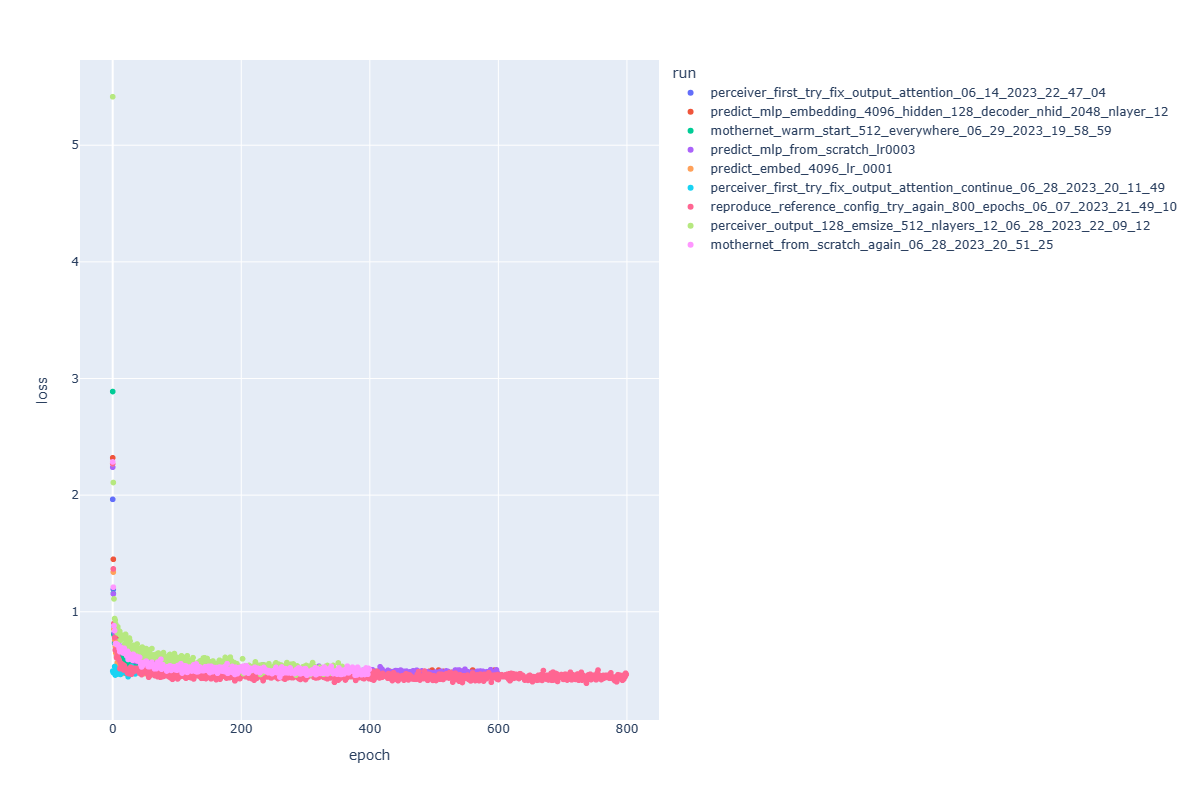

In [48]:
import plotly.express as px

show_only = ['predict_embed_4096_lr_0001', 'predict_mlp_no_token_embed_1024',
             'predict_mlp_embedding_4096_hidden_128_decoder_nhid_2048_nlayer_12',            
             'predict_mlp_from_scratch_lr0003',
            'reproduce_reference_config_try_again_800_epochs_06_07_2023_21_49_10',
             'perceiver_first_try_fix_output_attention_06_14_2023_22_47_04', 'perceiver_first_try_fix_output_attention_continue_06_28_2023_20_11_49',
            'mothernet_from_scratch_again_06_28_2023_20_51_25', 'perceiver_output_128_emsize_512_nlayers_12_06_28_2023_22_09_12', 'mothernet_warm_start_512_everywhere_06_29_2023_19_58_59'
            ]

long_df = make_long_loss_df(losses_dict)
long_df = long_df[long_df.run.isin(show_only)]
fig = px.scatter(long_df, x="epoch", y='loss', color="run")
fig.update_layout(height=800)
fig

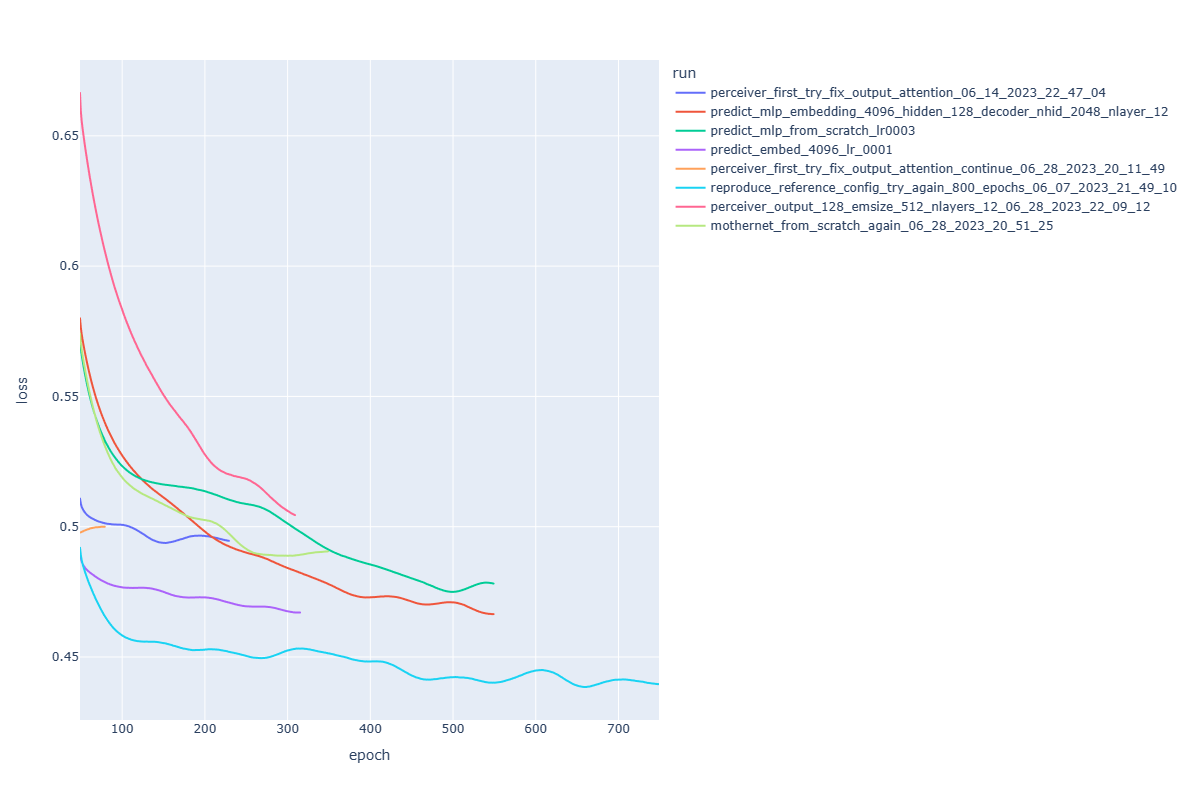

In [49]:
from scipy.signal import convolve, windows
import numpy as np
from scipy.signal import savgol_filter
# yhat = savgol_filter(y, 51, 3) # window size 51, polynomial order 3
#window = windows.gaussian(50, 10)
window = windows.gaussian(100, 20)
# window = windows.gaussian(20, 4)
window /= window.sum()
long_df = make_long_loss_df(losses_dict, smooth=lambda x : convolve(x, window, mode="valid") if x else [])
#long_df = make_long_loss_df(losses_dict, smooth=lambda x : savgol_filter(x[30:], 51, 3, mode='nearest') if x and len(x) > 82 else [])
long_df = long_df[long_df.run.isin(show_only)]
fig = px.line(long_df, x="epoch", y='loss', color="run")
fig.update_layout(height=800)

In [9]:
from tabpfn.scripts.model_builder import load_model

In [22]:
last_saves[model_string]

('models_diff/mothernet_from_scratch_again_06_28_2023_20_51_25_epoch_350.cpkt',
 350)

In [25]:
model_string = 'reproduce_reference_config_try_again_800_epochs_06_07_2023_21_49_10'
m, c = load_model(last_saves[model_string][0], device='cpu')

Using a Transformer with 25.83 M parameters
Using cpu device
learning rate:0.0001
steps_per_epoch:256


In [26]:
last_saves[model_string][0]

'models_diff/reproduce_reference_config_try_again_800_epochs_06_07_2023_21_49_10_epoch_on_exit.cpkt'

In [24]:
c

{'lr': 0.0001,
 'dropout': 0.0,
 'emsize': 512,
 'batch_size': 64,
 'nlayers': 12,
 'num_features': 100,
 'nhead': 4,
 'nhid_factor': 2,
 'bptt': 1152,
 'eval_positions': [1094],
 'seq_len_used': 50,
 'sampling': 'normal',
 'epochs': 800,
 'num_steps': 256,
 'verbose': False,
 'mix_activations': False,
 'pre_sample_causes': True,
 'multiclass_type': 'rank',
 'nan_prob_unknown_reason_reason_prior': 0.5,
 'categorical_feature_p': 0.2,
 'nan_prob_no_reason': 0.0,
 'nan_prob_unknown_reason': 0.0,
 'nan_prob_a_reason': 0.0,
 'max_num_classes': 10,
 'num_classes': <function priors.utils.<lambda>.<locals>.<lambda>()>,
 'noise_type': 'Gaussian',
 'balanced': False,
 'normalize_to_ranking': False,
 'set_value_to_nan': 0.1,
 'normalize_by_used_features': True,
 'num_features_used': {'uniform_int_sampler_f(3,max_features)': <function tabpfn.priors.utils.<lambda>.<locals>.<lambda>()>},
 'num_categorical_features_sampler_a': -1.0,
 'differentiable_hyperparameters': {'prior_bag_exp_weights_1': {'dis

In [16]:
m, c = load_model("models_diff/prior_diff_real_checkpoint_embed_dim_2048_warm_start_from_tabpfn_multiclass_05_10_2023_17_02_20_n_0_epoch_on_exit.cpkt", device="cpu")

In [17]:
c

{'lr': 0.0001,
 'dropout': 0.0,
 'emsize': 512,
 'batch_size': 16,
 'nlayers': 12,
 'num_features': 100,
 'nhead': 4,
 'nhid_factor': 2,
 'bptt': 1152,
 'eval_positions': [1094],
 'seq_len_used': 50,
 'sampling': 'normal',
 'epochs': 600,
 'num_steps': 1024,
 'verbose': False,
 'mix_activations': False,
 'pre_sample_causes': True,
 'multiclass_type': 'rank',
 'nan_prob_unknown_reason_reason_prior': 0.5,
 'categorical_feature_p': 0.2,
 'nan_prob_no_reason': 0.0,
 'nan_prob_unknown_reason': 0.0,
 'nan_prob_a_reason': 0.0,
 'max_num_classes': 10,
 'num_classes': '<function <lambda>.<locals>.<lambda> at 0x7f9966938290>',
 'noise_type': 'Gaussian',
 'balanced': False,
 'normalize_to_ranking': False,
 'set_value_to_nan': 0.1,
 'normalize_by_used_features': True,
 'num_features_used': {'uniform_int_sampler_f(3,max_features)': '<function <lambda>.<locals>.<lambda> at 0x7f99669380e0>'},
 'num_categorical_features_sampler_a': -1.0,
 'differentiable_hyperparameters': {'prior_bag_exp_weights_1': {

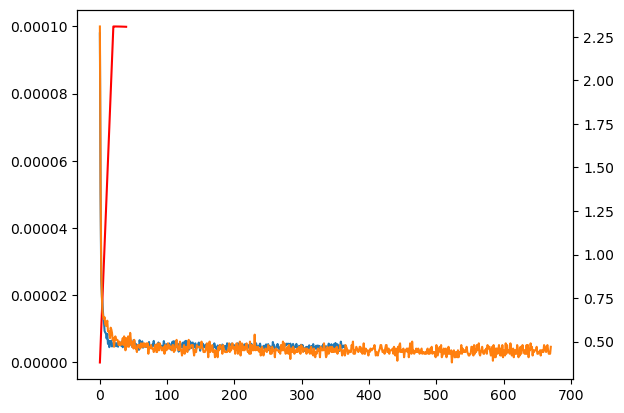

Bad pipe message: %s [b'#e\x83\xa2\x965\xe6\xa0\x0fH\x1f\x85)E.\xee\xd7\x88 \xe1\x8e\x83QY\xdf\xce\xc5\xdc\x08\xf5\xea\xdc\xaa\x87\r\xb4\xa6\x1e\x0c\x0eZ\x13\xea\xe9\n\xd8\xd6;P\x9dV\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08']
Bad pipe message: %s [b'\n\x08\x0b\x08\x04\x08\x05\x08']
Bad pipe message: %s [b'\x01\x05\x01\x06\x01']
Bad pipe message: %s [b"{FV\xfb\xaf\xd0\xa0\x853\x03#\x85A\x158\xfb\xb4[\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0", b'3\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0']
Ba

In [369]:
import matplotlib.pyplot as plt
#plt.plot(lr_dict['lr_001'], c='g')
plt.plot(lr_dict['really_big_model_lr00001_model_maker_warm_start'], c='r')
#plt.plot(lr_dict['onehot_classes'], c='b')


ax = plt.twinx()
#ax.plot(losses_dict['lr_001'])
ax.plot(losses_dict['predict_embed_4096_lr_0001'])
ax.plot(losses_dict['onehot_classes'])


In [354]:
locals()['meh'] = 1

In [355]:
meh

1